In [53]:
import sys
sys.path.append('../utils/')
sys.path.append('../../methyl_circuits/')
from ham_comp_utils import generate_heisenberg_hamiltonian
from direct_sim_utils import qutip_ref_sim, jump_sz_sz, time_trace_renormdm
from basis_utils import Sx,Sy,Sz,S_plus,S_minus
import cirq
from qutip import basis, tensor, qeye, sigmax,Qobj
import numpy as np
import qutip
import openfermion as of
from scipy import sparse
from matplotlib import pyplot as plt
from openfermion import count_qubits,hermitian_conjugated, get_sparse_operator
from nmrfuncs import (SzTot_weighted_obs, 
                      responseFunc_sample, 
                      ZULF_circuitList,
                      basisStates_positiveSz,
                      basisStates_positiveSz_ZULF, 
                      ZULF_noiselessSim)
from noisy_simulation.cirq_utils import get_two_zoned_noisy_circ, optimize_circuit_to_cz_gate_set


from copy import copy, deepcopy

In [28]:
basisStates_positiveSz(4)

(array([15, 14, 13, 11,  7]), array([2., 1., 1., 1., 1.]))

In [ ]:
###For simulation of FIDs. Target: following a bottom-up approach, we start with Heisenberg-type simple model, and compare with noisy simulations using our
#"naive" compilation approach, and with the compressed circuits

def apodize_exp1d(St, k):
    St_fixed = deepcopy(St); St_fixed[0] = 0.5 * St_fixed[0]  # fixes double counting in the FFT so that the spectrum correctly starts at zero instead of having a constant shift
    x = np.linspace(0, 1, St_fixed.size)
    return St_fixed * np.exp(-1 * k * x)


def ZULF_noiselessSim(t_ind_List, path, nmr_reg, weights,json_format=True):
    simulator = cirq.Simulator()
    responseFunc = []
    SzTot = np.array(SzTot_weighted_obs(len(nmr_reg), weights))
    for indt, t_ind in enumerate(t_ind_List):
        circuitList, SzTot_comp = ZULF_circuitList(t_ind, path, nmr_reg, SzTot,json_format=json_format)
        state_prob_list = []
        for circuit in circuitList:
            # Simulation (noiseless)
            vec = simulator.simulate(circuit).final_state_vector
            avg_pop = np.abs(vec)**2
            state_prob_list.append(avg_pop)
        responseFunc.append(responseFunc_sample(state_prob_list, SzTot, SzTot_comp, len(nmr_reg)))
    return responseFunc



def ZULF_noisySim_QuEra(t_ind_List, path, nmr_reg, weights, repetitions):
    simulator = cirq.DensityMatrixSimulator()
    responseFunc = []
    SzTot = np.array(SzTot_weighted_obs(len(nmr_reg), weights))
    for indt, t_ind in enumerate(t_ind_List):
        circuitList, SzTot_comp = ZULF_circuitList(t_ind, path, nmr_reg, SzTot)
        state_prob_list = []
        for circuit in circuitList:
            noisy_circuit = get_two_zoned_noisy_circ(optimize_circuit_to_cz_gate_set(circuit)) #addDepolarizingNoise(circuit, p1q, p2q)
            noisy_circuit.append([cirq.measure(*nmr_reg, key='measure_all')])
            run_result = simulator.run(program=noisy_circuit, repetitions=repetitions)
            histogram = run_result.histogram(key='measure_all')
            avg_pop = np.array([histogram[i] for i in range(int(2**len(nmr_reg)))])/repetitions
            state_prob_list.append(avg_pop)
#         print(indt)
        responseFunc.append(responseFunc_sample(state_prob_list, SzTot, SzTot_comp, len(nmr_reg)))
    return responseFunc


In [ ]:
###Just for testing of subroutines...
def ghz_circuit(n_qubits: int):
    # Define qubits
    qubits = cirq.LineQubit.range(n_qubits)

    # Create circuit
    circuit = cirq.Circuit()

    # Apply Hadamard to the first qubit
    circuit.append(cirq.H(qubits[0]))

    # Apply a chain of CNOTs
    for i in range(n_qubits - 1):
        circuit.append(cirq.CNOT(qubits[0], qubits[i + 1]))

    return circuit


In [54]:
h_list = [1.0, 1.0, 1.0]  # h_i for qubits 0, 1, 2
coupling_graph = [
    (0, 1, 2.0),  # J_{0,1}
    (1, 2, 1.5),  # J_{1,2}
]

hamiltonian = generate_heisenberg_hamiltonian(h_list, coupling_graph)
print(hamiltonian)

2.0 [X0 X1] +
2.0 [Y0 Y1] +
1.0 [Z0] +
2.0 [Z0 Z1] +
1.5 [X1 X2] +
1.5 [Y1 Y2] +
1.0 [Z1] +
1.5 [Z1 Z2] +
1.0 [Z2]


In [55]:
###Reference calculation...
nqubs = of.count_qubits(hamiltonian)

time = 10.0
t_steps = 500
deltaT= time/t_steps
kappa = 10.0
prop_steps = 50 ###number of steps to  simulate

L = np.sqrt(kappa)*jump_sz_sz(0, 1, nqubs)
L2 = np.sqrt(kappa)*jump_sz_sz(1,2,nqubs)
#jump_ops = [L]
jump_ops = [L,L2]
#e_ops = [total_magnetization_x(nqubs)]
local_sx = tensor([qeye(2),sigmax(),qeye(2)])
e_ops = [local_sx]
psi0 = tensor([basis(2, 0), basis(2, 1), basis(2, 0)])+tensor([basis(2, 0), basis(2, 0), basis(2, 0)])
psi0 = (1.0/np.sqrt(2))*psi0
####extend the "space" of the initial vector
#psi0 = tensor([psi0]+[basis(2,0)]*len(jump_ops))


res_diss, res_clean = qutip_ref_sim(hamiltonian,psi0,deltaT,Nsteps=prop_steps,c_ops=jump_ops,e_ops=e_ops)




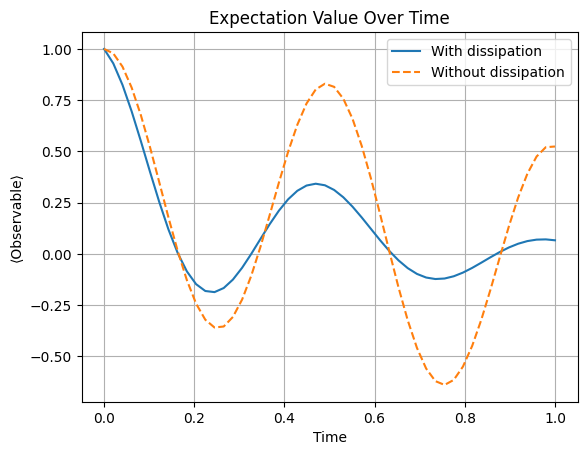

In [56]:
#Access times
times = res_diss.times  # Same as the times array you created

# Access expectation values (list of arrays: one per observable)
expect_diss = res_diss.expect[0]  # Only one observable here
expect_clean = res_clean.expect[0]

# Plotting
plt.plot(times, expect_diss, label="With dissipation")
plt.plot(times, expect_clean, label="Without dissipation", linestyle='--')
plt.xlabel("Time")
plt.ylabel("⟨Observable⟩")
plt.title("Expectation Value Over Time")
plt.legend()
plt.grid(True)
plt.show()

In [57]:
#####We build the system qubit's by hand at the state vector level
nqubs = of.count_qubits(hamiltonian)
#init_state = np.zeros(2**nqubs)
#init_state[2] = 1.0
#kappa = 0.001
#time = 1.0
#t_steps = 100

###Building a single jump operator by hand...
#JumpOp = [np.sqrt(kappa)*Sz(0)*Sz(1)]
JumpOp = [np.sqrt(kappa)*Sz(0)*Sz(1), np.sqrt(kappa)*Sz(1)*Sz(2)]
##Target observable: total polarization along Z:
#Tot_pol = of.QubitOperator()
#for i in range(nqubs):
#    Tot_pol+=Sz(i)

####checking the impact of discretization on time...

####extend the "space" of the initial vector
psi0 = tensor([psi0]+[basis(2,0)]*len(jump_ops))

f = 1

deltaT_ =deltaT/f
prop_steps_ = f*prop_steps

times_ = np.linspace(0,prop_steps*deltaT,prop_steps_)

#pol_trace = time_trace_of_obs_from_circs(hamiltonian,JumpOp,sparse.csr_matrix(local_sx.full()),prop_steps*deltaT,prop_steps_, psi0.full())
pol_trace = time_trace_renormdm(hamiltonian,JumpOp,sparse.csr_matrix(local_sx.full()),prop_steps*deltaT,prop_steps_,init_state=psi0.full())

In [58]:
###Taking a look at a Trotter step....
from ham_comp_utils import FirstOrderTrotterEvol, get_dil_Ham

sys_qub_reg = cirq.LineQubit.range(3)
anc_qub_reg = cirq.LineQubit.range(3,5)


dil_ham = get_dil_Ham(hamiltonian,deltaT,JumpOp)

FirstOrderTrotterEvol(sys_qub_reg,anc_qub_reg, dil_ham,deltaT, n_steps=1)

0: ───Rz(0.013π)─────────────────────────────Ry(0.5π)───@────────────────@───Ry(-0.5π)───Rx(-0.5π)───@────────────────@───Rx(0.5π)───@────────────────@───────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────@────────────────────────@───────────────────────────────────────────────────────────────────────
                                                        │                │                           │                │              │                │                                                                                                                           │                        │
1: ────────────────Rz(0.013π)────────────────Ry(0.5π)───X───Rz(0.025π)───X───Ry(-0.5π)───Rx(-0.5π)───X───Rz(0.025π)───X───Rx(0.5π)───X───Rz(0.025π)───X───Ry(0.5π)───@────────────────@───Ry(-0.5π)───Rx(-0.5π)───@────────────────@───Rx(0.5π)───@────────────────@──────────────X───@────────────────@───X──────────────────────────@────────────────────────@───────────────────
                                                                                                                                                                     │                │                           │                │              │                │                  │                │                              │                        │
2: ─────────────────────────────Rz(0.013π)────────────────────────────────────────────────────────────────────────────────────────────────────────────────Ry(0.5π)───X───Rz(0.019π)───X───Ry(-0.5π)───Rx(-0.5π)───X───Rz(0.019π)───X───Rx(0.5π)───X───Rz(0.019π)───X──────────────────┼────────────────┼──────────────────────────────X───@────────────────@───X───────────────────
                                                                                                                                                                                                                                                                                      │                │                                  │                │
3: ────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────Ry(0.5π)───────X───Rz(0.071π)───X───────Ry(-0.5π)───R──────────────┼────────────────┼───────────────────────
                                                                                                                                                                                                                                                                                                                                          │                │
4: ────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────Ry(0.5π)───────X───Rz(0.071π)───X───────Ry(-0.5π)───R───

/Users/luismartinezmartinez/pyenvs/qiskit1.1/lib/python3.11/site-packages/matplotlib/cbook.py:1762: ComplexWarning: Casting complex values to real discards the imaginary part
  return math.isfinite(val)
/Users/luismartinezmartinez/pyenvs/qiskit1.1/lib/python3.11/site-packages/matplotlib/cbook.py:1398: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


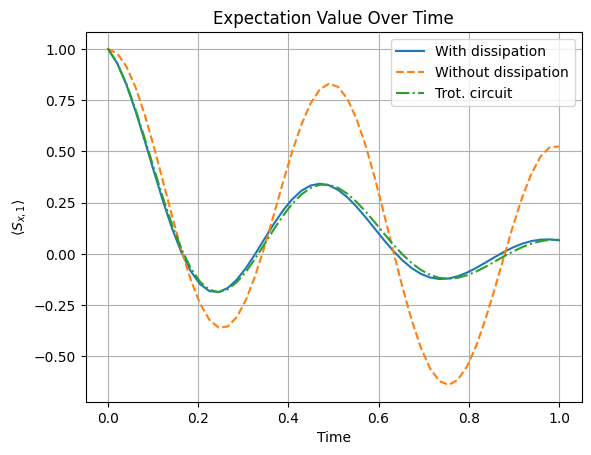

In [6]:
plt.plot(times, expect_diss, label="With dissipation")
plt.plot(times, expect_clean, label="Without dissipation", linestyle='--')
plt.plot(times_,pol_trace,label="Trot. circuit",linestyle='-.')
plt.xlabel("Time")
plt.ylabel(r"$\langle S_{x,1}\rangle$")
plt.title("Expectation Value Over Time")
plt.legend()
plt.grid(True)
plt.show()


# Calculation of NMR spectra with compiled circuits. The acetonitrile case

In [35]:
from ham_comp_utils import compile_group

def decode_integer_to_statevector(index: int, num_qubits: int) -> np.ndarray:
    """Return the computational basis state vector |index⟩ for a system of num_qubits.
    
    Args:
        index: Integer corresponding to the computational basis state.
        num_qubits: Total number of qubits in the system.

    Returns:
        A numpy array representing the state vector with a 1 at position `index`.
    """
    dimension = 2 ** num_qubits
    if index < 0 or index >= dimension:
        raise ValueError(f"Index {index} is out of range for {num_qubits} qubits.")

    statevector = np.zeros(dimension, dtype=complex)
    statevector[index] = 1.0
    return statevector


In [22]:
#Noiseless Hamiltonian evolution to get the FID from circuit simulations...

#Parameters for the model....

lowfield = False

sweep_Hz = 700; npoints = 4096; timestep = 1 / sweep_Hz
gamma_1H = 2.6752 * 1e8; gamma_13C = 0.6728 * 1e8
weights = np.array([gamma_1H, gamma_1H, gamma_1H, gamma_13C]) / gamma_1H

timestep = 1 / sweep_Hz
tgrid = timestep * np.array([i for i in range(npoints)])
# tgrid = (timestep / 2) * np.array([i for i in range(2 * npoints)])
fgrid = np.fft.fftshift(np.fft.fftfreq(npoints, timestep))

Jij_Hz_zf = np.array([[0, 0, 0, 136.2],
                    [0, 0, 0, 136.2],
                    [0, 0, 0, 136.2],
                    [136.2, 136.2, 136.2, 0]])

Jij_Hz_ulf = np.array([[-11.2405, 0, 0, 136.2],
                        [0, -11.2405, 0, 136.2],
                        [0, 0, -11.2405, 136.2],
                        [136.2, 136.2, 136.2, -2.827]])


if lowfield:
    Jij_Hz = Jij_Hz_ulf
    nstring = 'ulf'
else:
    Jij_Hz = Jij_Hz_zf
    nstring = 'zf'

hamMat_radHz = 2 * np.pi * Jij_Hz

N = hamMat_radHz.shape[0]
hiList = [[hamMat_radHz[i, i], i] for i in np.arange(N)]  # extracts hi from parameter matrix (puts in form for QuSpin)
JijList = [[hamMat_radHz[i, j], i, j] for i in np.arange(N) for j in np.arange(N) if (i != j) and (i < j) if not np.isclose(hamMat_radHz[i, j], 0)]

h_list = [hamMat_radHz[i, i] for i in np.arange(N)]
J_coup_grap = [(i,j,hamMat_radHz[i, j]) for i in np.arange(N) for j in np.arange(N) if (i != j) and (i < j) if not np.isclose(hamMat_radHz[i, j], 0)]


#####Interface to the built pipeline....

hamiltonian = generate_heisenberg_hamiltonian(h_list, J_coup_grap)
print(hamiltonian)




855.7698388378595 [X0 X3] +
855.7698388378595 [Y0 Y3] +
855.7698388378595 [Z0 Z3] +
855.7698388378595 [X1 X3] +
855.7698388378595 [Y1 Y3] +
855.7698388378595 [Z1 Z3] +
855.7698388378595 [X2 X3] +
855.7698388378595 [Y2 Y3] +
855.7698388378595 [Z2 Z3]


In [34]:
tgrid

array([0.00000000e+00, 1.42857143e-03, 2.85714286e-03, ...,
       5.84714286e+00, 5.84857143e+00, 5.85000000e+00])

In [ ]:
#####The problem of calculating an FID for this small simple system reduces to propagate and estimate total magnetization for the target time grid...





In [45]:

SzTot_weighted_obs(4, weights)

array([ 1.62574761,  1.37425239,  0.62574761,  0.37425239,  0.62574761,
        0.37425239, -0.37425239, -0.62574761,  0.62574761,  0.37425239,
       -0.37425239, -0.62574761, -0.37425239, -0.62574761, -1.37425239,
       -1.62574761])

In [50]:
SzTot = np.array(SzTot_weighted_obs(4, weights))
bin_encs,m_vals= basisStates_positiveSz_ZULF(4,SzTot)


Sz_mat = np.diag(SzTot)


In [51]:
nqubs=4
sim = cirq.Simulator()
qub_reg = cirq.LineQubit.range(nqubs)
FID= np.zeros(len(tgrid))

for j in range(len(tgrid)):
    fid_t = 0.0
    for i in range(len(bin_encs)):

        init_state = decode_integer_to_statevector(bin_encs[i], nqubs) ###TODO

        tar_ham = hamiltonian*tgrid[j]
        res = sim.simulate(compile_group(qub_reg,tar_ham),initial_state=init_state)

        prop_wf = res.final_state_vector
        fid_t+=m_vals[i]*np.vdot(prop_wf,Sz_mat@prop_wf)

    FID[j] = fid_t





/var/folders/rm/xdxcjr7n7_13f9m1905zyf6c0000gq/T/ipykernel_76597/2675794326.py:18: ComplexWarning: Casting complex values to real discards the imaginary part
  FID[j] = fid_t
/var/folders/rm/xdxcjr7n7_13f9m1905zyf6c0000gq/T/ipykernel_76597/2675794326.py:18: ComplexWarning: Casting complex values to real discards the imaginary part
  FID[j] = fid_t
/var/folders/rm/xdxcjr7n7_13f9m1905zyf6c0000gq/T/ipykernel_76597/2675794326.py:18: ComplexWarning: Casting complex values to real discards the imaginary part
  FID[j] = fid_t
/var/folders/rm/xdxcjr7n7_13f9m1905zyf6c0000gq/T/ipykernel_76597/2675794326.py:18: ComplexWarning: Casting complex values to real discards the imaginary part
  FID[j] = fid_t
/var/folders/rm/xdxcjr7n7_13f9m1905zyf6c0000gq/T/ipykernel_76597/2675794326.py:18: ComplexWarning: Casting complex values to real discards the imaginary part
  FID[j] = fid_t
/var/folders/rm/xdxcjr7n7_13f9m1905zyf6c0000gq/T/ipykernel_76597/2675794326.py:18: ComplexWarning: Casting complex values to 

KeyboardInterrupt: 

(16,)

In [42]:
SzTot@prop_wf

np.complex128(-1.6257476076555024+0j)

In [26]:
###Just checking compilation of Hamiltonian, single Trotter step...
qub_reg = cirq.LineQubit.range(4)
compile_group(qub_reg,hamiltonian)


0: ───Ry(0.5π)───@──────────────@───Ry(-0.5π)───Rx(-0.5π)───@──────────────@───Rx(0.5π)───@──────────────@─────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
                 │              │                           │              │              │              │
1: ──────────────┼──────────────┼───────────────────────────┼──────────────┼──────────────┼──────────────┼───Ry(0.5π)───@──────────────@───Ry(-0.5π)───Rx(-0.5π)───@──────────────@───Rx(0.5π)───@──────────────@──────────────────────────────────────────────────────────────────────────────────────────────────────────
                 │              │                           │              │              │              │              │              │                           │              │              │              │
2: ──────────────┼──────────────┼───────────────────────────┼──────────────┼──────────────┼──────────────┼──────────────┼──────────────┼───────────────────────────┼──────────────┼──────────────┼──────────────┼───Ry(0.5π)───@──────────────@───Ry(-0.5π)───Rx(-0.5π)───@──────────────@───Rx(0.5π)───@──────────────@───
                 │              │                           │              │              │              │              │              │                           │              │              │              │              │              │                           │              │              │              │
3: ───Ry(0.5π)───X───Rz(0.4π)───X───Ry(-0.5π)───Rx(-0.5π)───X───Rz(0.4π)───X───Rx(0.5π)───X───Rz(0.4π)───X───Ry(0.5π)───X───Rz(0.4π)───X───Ry(-0.5π)───Rx(-0.5π)───X───Rz(0.4π)───X───Rx(0.5π)───X───Rz(0.4π)───X───Ry(0.5π)───X───Rz(0.4π)───X───Ry(-0.5π)───Rx(-0.5π)───X───Rz(0.4π)───X───Rx(0.5π)───X───Rz(0.4π)───X───

In [23]:
J_coup_grap

[(np.int64(0), np.int64(3), np.float64(855.7698388378595)),
 (np.int64(1), np.int64(3), np.float64(855.7698388378595)),
 (np.int64(2), np.int64(3), np.float64(855.7698388378595))]

In [ ]:

[(i,j,hamMat_radHz[i, j]) for i in np.arange(N) for j in np.arange(N) if (i != j) and (i < j) if not np.isclose(hamMat_radHz[i, j], 0)]

[(np.int64(0), np.int64(3), np.float64(855.7698388378595)),
 (np.int64(1), np.int64(3), np.float64(855.7698388378595)),
 (np.int64(2), np.int64(3), np.float64(855.7698388378595))]

In [20]:
JijList

[[np.float64(855.7698388378595), np.int64(0), np.int64(3)],
 [np.float64(855.7698388378595), np.int64(1), np.int64(3)],
 [np.float64(855.7698388378595), np.int64(2), np.int64(3)]]

In [18]:
hiList

[[np.float64(0.0), np.int64(0)],
 [np.float64(0.0), np.int64(1)],
 [np.float64(0.0), np.int64(2)],
 [np.float64(0.0), np.int64(3)]]

In [13]:
test = np.array(hiList)


test.flatten()


array([0., 0., 0., 1., 0., 2., 0., 3.])

In [14]:
hiList

[[np.float64(0.0), np.int64(0)],
 [np.float64(0.0), np.int64(1)],
 [np.float64(0.0), np.int64(2)],
 [np.float64(0.0), np.int64(3)]]

In [10]:
JijList

[[np.float64(855.7698388378595), np.int64(0), np.int64(3)],
 [np.float64(855.7698388378595), np.int64(1), np.int64(3)],
 [np.float64(855.7698388378595), np.int64(2), np.int64(3)]]

# DEPRECATED

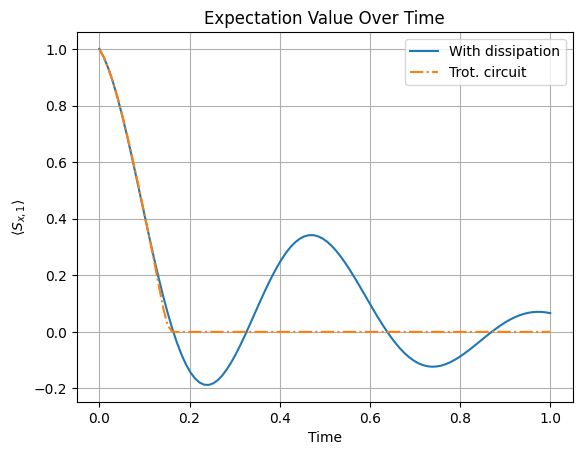

In [243]:
plt.plot(times, expect_diss, label="With dissipation")
#plt.plot(times, expect_clean, label="Without dissipation", linestyle='--')
plt.plot(times,pol_trace,label="Trot. circuit",linestyle='-.')
plt.xlabel("Time")
plt.ylabel(r"$\langle S_{x,1}\rangle$")
plt.title("Expectation Value Over Time")
plt.legend()
plt.grid(True)
plt.show()


In [ ]:
plt.plot(times, expect_diss, label="With dissipation")

array([[0.70710678+0.j],
       [0.        +0.j],
       [0.70710678+0.j],
       [0.        +0.j],
       [0.        +0.j],
       [0.        +0.j],
       [0.        +0.j],
       [0.        +0.j]])

In [263]:
JumpOp

[0.7905694150420949 [Z0 Z1], 0.7905694150420949 [Z1 Z2]]

In [266]:
deltaT

0.02

In [307]:
hamiltonian

2.0 [X0 X1] +
2.0 [Y0 Y1] +
1.0 [Z0] +
2.0 [Z0 Z1] +
1.5 [X1 X2] +
1.5 [Y1 Y2] +
1.0 [Z1] +
1.5 [Z1 Z2] +
1.0 [Z2]

In [317]:

ops = [qeye(2)] * 3  # Identity on all sites
ops[0] =  Qobj(np.array([[1.0,0.0],[0.0,0.0]]))             # Replace with S_z at position n
M0 = tensor(ops)  

In [325]:
np.shape(M0.full())

(8, 8)

In [332]:
####Debugging...
def remove_resets(circuit: cirq.Circuit) -> cirq.Circuit:
    """Returns a copy of the circuit with all reset operations removed."""
    new_moments = []
    for moment in circuit:
        filtered_ops = [op for op in moment.operations
                        if not isinstance(op.gate, (cirq.ResetChannel))]
        if filtered_ops:
            new_moments.append(cirq.Moment(filtered_ops))
    return cirq.Circuit(new_moments)

def apply_kraus_on_dm(dm,qub_idx):

    dim = dm.shape[0]
    nqubs = np.log2(dim)

    #M0 = np.zeros([dim,dim])
    #M1 = np.zeros([dim,dim])
    
    ops = [qeye(2)] * int(nqubs)  # Identity on all sites
    ops[qub_idx] =  Qobj(np.array([[1.0,0.0],[0.0,0.0]]))             # Replace with S_z at position n
    M0 = tensor(ops)  

    ops = [qeye(2)] * int(nqubs)  # Identity on all sites
    ops[qub_idx] =  Qobj(np.array([[0.0,1.0],[0.0,0.0]]))             # Replace with S_z at position n
    M1 = tensor(ops) 

    return M0.full()@dm@np.transpose(M0.full())+M1.full()@dm@np.transpose(M1.full())


n_sysqubs = of.count_qubits(hamiltonian)
nancs = len(JumpOp)

dil_ham = get_dil_Ham(hamiltonian,deltaT,JumpOp)

sys_qubit_reg = cirq.LineQubit.range(n_sysqubs)
anc_qub_reg = cirq.LineQubit.range(n_sysqubs,n_sysqubs+nancs)


Trot_circ = FirstOrderTrotterEvol(sys_qubit_reg,anc_qub_reg, dil_ham,deltaT, n_steps=15,key='m', parallel=True)
#red_dm = get_red_DM_from_circ(Trot_circ,sys_qubit_reg,init_state=psi0.full())

nqubs = len(Trot_circ.all_qubits())
sys_nqubs = len(sys_qubit_reg)
nancs = nqubs - sys_nqubs
init_state = psi0.full()

if init_state is None:
    init_state = np.zeros(2**nqubs)
    init_state[0] = 1.0
    rho0 = np.outer(init_state, init_state.conj())
else:
    sys_rho = np.outer(init_state,init_state.conj())
    anc_psi = np.zeros(2**nancs)
    anc_psi[0] = 1.0
    anc_rho = np.outer(anc_psi,anc_psi.conj())

    rho0 = np.kron(sys_rho,anc_rho)
#rho0 = np.outer(init_state, init_state.conj())

sim = cirq.DensityMatrixSimulator()
res = sim.simulate(Trot_circ,initial_state=rho0)

dm_with_resets = res.final_density_matrix



no_reset_circ = remove_resets(Trot_circ)

res = sim.simulate(no_reset_circ,initial_state=rho0)

dm_clean = res.final_density_matrix


#dm_kraus_on3 = apply_kraus_on_dm(dm_clean,3)

#dm_kraus_3_4 = apply_kraus_on_dm(dm_kraus_on3,4)

#indices = [q.x for q in sys_qubit_reg]
#print("System qubit indices:", indices)

#qutip.ptrace(to_qutip_qobj(dm),[0,1])


#return qutip.ptrace(to_qutip_qobj(dm),indices)








In [372]:
sim = cirq.DensityMatrixSimulator()
max_depth = 655

for depth in range(1, max_depth):
    truncated_circuit = Trot_circ[:depth]
    result = sim.simulate(truncated_circuit)
    rho = result.final_density_matrix
    rho = rho/np.trace(rho)
    print(f"Depth {depth}: Trace = {np.trace(rho):.6f}")

Depth 1: Trace = 1.000000+0.000000j
Depth 2: Trace = 1.000000+0.000000j
Depth 3: Trace = 1.000000+0.000000j
Depth 4: Trace = 1.000000+0.000000j
Depth 5: Trace = 1.000000+0.000000j
Depth 6: Trace = 1.000000+0.000000j
Depth 7: Trace = 1.000000+0.000000j
Depth 8: Trace = 1.000000+0.000000j
Depth 9: Trace = 1.000000+0.000000j
Depth 10: Trace = 1.000000+0.000000j
Depth 11: Trace = 1.000000+0.000000j
Depth 12: Trace = 1.000000+0.000000j
Depth 13: Trace = 1.000000+0.000000j
Depth 14: Trace = 1.000000+0.000000j
Depth 15: Trace = 1.000000-0.000000j
Depth 16: Trace = 1.000000-0.000000j
Depth 17: Trace = 1.000000+0.000000j
Depth 18: Trace = 1.000000+0.000000j
Depth 19: Trace = 1.000000+0.000000j
Depth 20: Trace = 1.000000+0.000000j
Depth 21: Trace = 1.000000+0.000000j
Depth 22: Trace = 1.000000+0.000000j
Depth 23: Trace = 1.000000+0.000000j
Depth 24: Trace = 1.000000+0.000000j
Depth 25: Trace = 1.000000+0.000000j
Depth 26: Trace = 1.000000+0.000000j
Depth 27: Trace = 1.000000+0.000000j
Depth 28: 

In [373]:
rho

array([[ 4.9999982e-01-7.4624396e-10j,  4.9999982e-01-7.4624396e-10j,
         0.0000000e+00+0.0000000e+00j, ...,
         8.5319691e-08-4.9842527e-08j,  0.0000000e+00+0.0000000e+00j,
         0.0000000e+00+0.0000000e+00j],
       [ 4.9999982e-01-7.4624396e-10j,  4.9999982e-01-7.4624396e-10j,
         0.0000000e+00+0.0000000e+00j, ...,
         8.5319691e-08-4.9842527e-08j,  0.0000000e+00+0.0000000e+00j,
         0.0000000e+00+0.0000000e+00j],
       [ 0.0000000e+00+0.0000000e+00j,  0.0000000e+00+0.0000000e+00j,
         0.0000000e+00+0.0000000e+00j, ...,
         0.0000000e+00+0.0000000e+00j,  0.0000000e+00+0.0000000e+00j,
         0.0000000e+00+0.0000000e+00j],
       ...,
       [-1.0881885e-08-2.1665040e-08j, -1.0881885e-08-2.1665040e-08j,
         0.0000000e+00+0.0000000e+00j, ...,
         1.0928461e-07+4.0873224e-10j,  0.0000000e+00+0.0000000e+00j,
         0.0000000e+00+0.0000000e+00j],
       [ 0.0000000e+00+0.0000000e+00j,  0.0000000e+00+0.0000000e+00j,
         0.0000000e+00

In [334]:
np.trace(dm_with_resets)

np.complex64(0.16725017-0.0008622449j)

In [333]:
np.trace(dm_clean)

np.complex64(0.99999386-6.12247e-08j)

In [327]:
np.linalg.norm(dm_with_resets-dm_kraus_3_4)

np.float64(1.3885464444759042e-06)

In [330]:
np.trace(dm_with_resets)

np.complex64(0.9999979-7.954001e-09j)

In [331]:
np.trace(dm_kraus_3_4)

np.complex128(0.9999993233530133-6.847443355160836e-10j)

In [316]:
no_reset_circ

0: ───Rz(0.013π)─────────────────────────────Ry(0.5π)───@────────────────@───Ry(-0.5π)───Rx(-0.5π)───@────────────────@───Rx(0.5π)───@────────────────@───────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────@────────────────────────@───────────────────────────────────────────────────────────────────
                                                        │                │                           │                │              │                │                                                                                                                           │                        │
1: ────────────────Rz(0.013π)────────────────Ry(0.5π)───X───Rz(0.025π)───X───Ry(-0.5π)───Rx(-0.5π)───X───Rz(0.025π)───X───Rx(0.5π)───X───Rz(0.025π)───X───Ry(0.5π)───@────────────────@───Ry(-0.5π)───Rx(-0.5π)───@────────────────@───Rx(0.5π)───@────────────────@──────────────X───@────────────────@───X──────────────────────────@────────────────────────@───────────────
                                                                                                                                                                     │                │                           │                │              │                │                  │                │                              │                        │
2: ─────────────────────────────Rz(0.013π)────────────────────────────────────────────────────────────────────────────────────────────────────────────────Ry(0.5π)───X───Rz(0.019π)───X───Ry(-0.5π)───Rx(-0.5π)───X───Rz(0.019π)───X───Rx(0.5π)───X───Rz(0.019π)───X──────────────────┼────────────────┼──────────────────────────────X───@────────────────@───X───────────────
                                                                                                                                                                                                                                                                                      │                │                                  │                │
3: ────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────Ry(0.5π)───────X───Rz(0.071π)───X───────Ry(-0.5π)──────────────────┼────────────────┼───────────────────
                                                                                                                                                                                                                                                                                                                                          │                │
4: ────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────Ry(0.5π)───────X───Rz(0.071π)───X───────Ry(-0.5π)───

In [285]:
cirq.DensityMatrixSimulator.simulate_expectation_values?

Signature:
cirq.DensityMatrixSimulator.simulate_expectation_values(
    self,
    program: 'cirq.AbstractCircuit',
    observables: Union[ForwardRef('cirq.PauliSumLike'), List[ForwardRef('cirq.PauliSumLike')]],
    param_resolver: 'cirq.ParamResolverOrSimilarType' = None,
    qubit_order: 'cirq.QubitOrderOrList' = <cirq.ops.qubit_order.QubitOrder object at 0x114997c10>,
    initial_state: Any = None,
    permit_terminal_measurements: bool = False,
) -> List[float]
Docstring:
Simulates the supplied circuit and calculates exact expectation
values for the given observables on its final state.

This method has no perfect analogy in hardware. Instead compare with
Sampler.sample_expectation_values, which calculates estimated
expectation values by sampling multiple times.

Args:
    program: The circuit to simulate.
    observables: An observable or list of observables.
    param_resolver: Parameters to run with the program.
    qubit_order: Determines the canonical ordering of the qubits. Th

In [282]:
Trot_circ

0: ───Rz(0.013π)─────────────────────────────Ry(0.5π)───@────────────────@───Ry(-0.5π)───Rx(-0.5π)───@────────────────@───Rx(0.5π)───@────────────────@───────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────@────────────────────────@───────────────────────────────────────────────────────────────────────Rz(0.013π)─────────────────────────────Ry(0.5π)───@────────────────@───Ry(-0.5π)───Rx(-0.5π)───@────────────────@───Rx(0.5π)───@────────────────@───────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────@────────────────────────@───────────────────────────────────────────────────────────────────────Rz(0.013π)─────────────────────────────Ry(0.5π)───@────────────────@───Ry(-0.5π)───Rx(-0.5π)───@────────────────@───Rx(0.5π)───@────────────────@───────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────@────────────────────────@───────────────────────────────────────────────────────────────────────Rz(0.013π)─────────────────────────────Ry(0.5π)───@────────────────@───Ry(-0.5π)───Rx(-0.5π)───@────────────────@───Rx(0.5π)───@────────────────@───────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────@────────────────────────@───────────────────────────────────────────────────────────────────────Rz(0.013π)─────────────────────────────Ry(0.5π)───@────────────────@───Ry(-0.5π)───Rx(-0.5π)───@────────────────@───Rx(0.5π)───@────────────────@───────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────@────────────────────────@───────────────────────────────────────────────────────────────────────Rz(0.013π)─────────────────────────────Ry(0.5π)───@────────────────@───Ry(-0.5π)───Rx(-0.5π)───@────────────────@───Rx(0.5π)───@────────────────@───────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────@────────────────────────@───────────────────────────────────────────────────────────────────────Rz(0.013π)─────────────────────────────Ry(0.5π)───@────────────────@───Ry(-0.5π)───Rx(-0.5π)───@────────────────@───Rx(0.5π)───@────────────────@───────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────@────────────────────────@───────────────────────────────────────────────────────────────────────Rz(0.013π)─────────────────────────────Ry(0.5π)───@────────────────@───Ry(-0.5π)───Rx(-0.5π)───@────────────────@───Rx(0.5π)───@────────────────@───────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────@────────────────────────@───────────────────────────────────────────────────────────────────────Rz(0.013π)─────────────────────────────Ry(0.5π)───@────────────────@───Ry(-0.5π)───Rx(-0.5π)───@────────────────@───Rx(0.5π)───@────────────────@───────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────@────────────────────────@───────────────────────────────────────────────────────────────────────Rz(0.013π)─────────────────────────────Ry(0.5π)───@────────────────@───Ry(-0.5π)───Rx(-0.5π)───@────────────────@───Rx(0.5π)───@────────────────@───────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────@────────────────────────@───────────────────────────────────────────────────────────────────────Rz(0.013π)─────────────────────────────Ry(0.5π)───@────────────────@───Ry(-0.5π)───Rx(-0.5π)───@────────────────@───Rx(0.5π)───@────────────────@───────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────@────────────────────────@──────────────────────────────────────────────────

In [283]:
np.shape(dm)

(32, 32)

In [284]:
np.trace(dm)

np.complex64(0.5050729-0.0009945668j)

In [306]:
import cirq
import numpy as np
import matplotlib.pyplot as plt

# Qubits
q_sys = cirq.NamedQubit("system")
q_env = cirq.NamedQubit("env")

# Damping probability γ
#gamma = 0.3
theta = np.pi/2

# Circuit
circuit = cirq.Circuit()

# Prepare system in |1⟩
circuit.append(cirq.X(q_sys))

# Controlled Ry(θ) from system to environment
controlled_ry = cirq.ControlledGate(cirq.ry(theta))
circuit.append(controlled_ry.on(q_sys, q_env))

# Reset environment qubit (tracing it out)
circuit.append(cirq.ResetChannel()(q_env))

# Measure the system qubit
#circuit.append(cirq.measure(q_sys, key="z"))

# Simulate
sim = cirq.DensityMatrixSimulator()
results = sim.simulate(circuit)


results.final_density_matrix
# Plot
#counts = results.histogram(key="z")
#plt.bar(["0", "1"], [counts.get(0, 0), counts.get(1, 0)])
#plt.ylabel("Counts")
#plt.title(f"Amplitude Damping on System Qubit (γ = {gamma})")
#plt.show()


array([[0.       +0.j, 0.       +0.j, 0.       +0.j, 0.       +0.j],
       [0.       +0.j, 0.9999999+0.j, 0.       +0.j, 0.       +0.j],
       [0.       +0.j, 0.       +0.j, 0.       +0.j, 0.       +0.j],
       [0.       +0.j, 0.       +0.j, 0.       +0.j, 0.       +0.j]],
      dtype=complex64)

In [304]:
circuit

env: ──────────Ry(0.5π)───R───
               │
system: ───X───@──────────────

<bound method SimulationTrialResultBase.get_state_containing_qubit of cirq.DensityMatrixTrialResult(params=cirq.ParamResolver({}), measurements={}, final_simulator_state=<cirq.sim.simulation_product_state.SimulationProductState object at 0x119400e50>)>

In [288]:
q_env = cirq.NamedQubit("env")
circuit = cirq.Circuit()
res_gate = cirq.ResetChannel()(q_env)
circuit.append(res_gate)

In [291]:
res_gate._has_kraus_()

True

In [191]:
test = results.final_density_matrix

In [192]:
test

array([[0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j],
       [0.+0.j, 1.+0.j, 0.+0.j, 0.+0.j],
       [0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j],
       [0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j]], dtype=complex64)

In [193]:
#test = qutip.ptrace(to_qutip_qobj(dm),indices)

qutip.ptrace(to_qutip_qobj(test),[0])

Quantum object: dims=[[2], [2]], shape=(2, 2), type='oper', dtype=Dense, isherm=True
Qobj data =
[[1. 0.]
 [0. 0.]]

In [182]:
np.trace(test.full())

np.complex128(0.9988134154765205-3.6467171080385286e-05j)

In [174]:
Trot_circ

0: ───Rz(0.032π)─────────────────────────────Ry(0.5π)───@────────────────@───Ry(-0.5π)───Rx(-0.5π)───@────────────────@───Rx(0.5π)───@────────────────@────────────────────────────────────────────────────────────────────────────────────────────────────────────@────────────────────────@───────────────────Rz(0.032π)─────────────────────────────Ry(0.5π)───@────────────────@───Ry(-0.5π)───Rx(-0.5π)───@────────────────@───Rx(0.5π)───@────────────────@────────────────────────────────────────────────────────────────────────────────────────────────────────────@────────────────────────@───────────────────Rz(0.032π)─────────────────────────────Ry(0.5π)───@────────────────@───Ry(-0.5π)───Rx(-0.5π)───@────────────────@───Rx(0.5π)───@────────────────@────────────────────────────────────────────────────────────────────────────────────────────────────────────@────────────────────────@───────────────────Rz(0.032π)─────────────────────────────Ry(0.5π)───@────────────────@───Ry(-0.5π)───Rx(-0.5π)───@────────────────@───Rx(0.5π)───@────────────────@────────────────────────────────────────────────────────────────────────────────────────────────────────────@────────────────────────@───────────────────Rz(0.032π)─────────────────────────────Ry(0.5π)───@────────────────@───Ry(-0.5π)───Rx(-0.5π)───@────────────────@───Rx(0.5π)───@────────────────@────────────────────────────────────────────────────────────────────────────────────────────────────────────@────────────────────────@───────────────────Rz(0.032π)─────────────────────────────Ry(0.5π)───@────────────────@───Ry(-0.5π)───Rx(-0.5π)───@────────────────@───Rx(0.5π)───@────────────────@────────────────────────────────────────────────────────────────────────────────────────────────────────────@────────────────────────@───────────────────Rz(0.032π)─────────────────────────────Ry(0.5π)───@────────────────@───Ry(-0.5π)───Rx(-0.5π)───@────────────────@───Rx(0.5π)───@────────────────@────────────────────────────────────────────────────────────────────────────────────────────────────────────@────────────────────────@───────────────────Rz(0.032π)─────────────────────────────Ry(0.5π)───@────────────────@───Ry(-0.5π)───Rx(-0.5π)───@────────────────@───Rx(0.5π)───@────────────────@────────────────────────────────────────────────────────────────────────────────────────────────────────────@────────────────────────@───────────────────Rz(0.032π)─────────────────────────────Ry(0.5π)───@────────────────@───Ry(-0.5π)───Rx(-0.5π)───@────────────────@───Rx(0.5π)───@────────────────@────────────────────────────────────────────────────────────────────────────────────────────────────────────@────────────────────────@───────────────────Rz(0.032π)─────────────────────────────Ry(0.5π)───@────────────────@───Ry(-0.5π)───Rx(-0.5π)───@────────────────@───Rx(0.5π)───@────────────────@────────────────────────────────────────────────────────────────────────────────────────────────────────────@────────────────────────@───────────────────Rz(0.032π)─────────────────────────────Ry(0.5π)───@────────────────@───Ry(-0.5π)───Rx(-0.5π)───@────────────────@───Rx(0.5π)───@────────────────@────────────────────────────────────────────────────────────────────────────────────────────────────────────@────────────────────────@───────────────────Rz(0.032π)─────────────────────────────Ry(0.5π)───@────────────────@───Ry(-0.5π)───Rx(-0.5π)───@────────────────@───Rx(0.5π)───@────────────────@────────────────────────────────────────────────────────────────────────────────────────────────────────────@────────────────────────@───────────────────Rz(0.032π)─────────────────────────────Ry(0.5π)───@────────────────@───Ry(-0.5π)───Rx(-0.5π)───@────────────────@───Rx(0.5π)───@────────────────@────────────────────────────────────────────────────────────────────────────────────────────────────────────@────────────────────────@───────────────────Rz(0.032π)─────────────────────────────Ry(0.5π)───@────────────────@───Ry(-0.5π)───Rx(-0.5π)───@────────────────@───Rx(0

In [24]:
init_state

array([0., 0., 1., 0., 0., 0., 0., 0.])

In [69]:
time = 2.0
t_steps = 1000
deltaT = time/t_steps
kappa = 0.001
JumpOp = [np.sqrt(kappa)*Sz(0)*Sz(1)]
sys_qubit_reg = cirq.LineQubit.range(nqubs)

#sys_qubit_reg = cirq.LineQubit.range(n_sysqubs)
anc_qub_reg = cirq.LineQubit.range(nqubs,nqubs+1)
dil_ham = get_dil_Ham(hamiltonian,deltaT,JumpOp)
    
Trot_circ = FirstOrderTrotterEvol(sys_qubit_reg,anc_qub_reg, dil_ham,deltaT, n_steps=25,key='m', parallel=True)



test = get_red_DM_from_circ(Trot_circ,sys_qubit_reg,init_state=init_state)

System qubit indices: [0, 1, 2]


In [70]:
np.linalg.eigvals(test.full())

array([ 4.00974433e-10-2.08421324e-13j, -3.11274466e-16-3.98288339e-19j,
       -1.36829089e-16+4.95242406e-19j, -1.55647966e-20+6.53906599e-21j,
        0.00000000e+00+0.00000000e+00j,  0.00000000e+00+0.00000000e+00j,
        0.00000000e+00+0.00000000e+00j,  0.00000000e+00+0.00000000e+00j])

In [67]:
np.linalg.eigvals(test.full())

array([ 5.08566835e-01-8.26067558e-06j, -3.54457150e-07-2.79344141e-11j,
       -9.54811156e-08+2.42797708e-10j, -2.42432672e-11+1.22553753e-11j,
        0.00000000e+00+0.00000000e+00j,  0.00000000e+00+0.00000000e+00j,
        0.00000000e+00+0.00000000e+00j,  0.00000000e+00+0.00000000e+00j])

In [66]:
Trot_circ

0: ───Rz(0)───────────────────Ry(0.5π)───@───────────@───Ry(-0.5π)───Rx(-0.5π)───@───────────@───Rx(0.5π)───@───────────@────────────────────────────────────────────────────────────────────────────────────────────────────────────@───────────────────@────────────────────────────Rz(0)───────────────────Ry(0.5π)───@───────────@───Ry(-0.5π)───Rx(-0.5π)───@───────────@───Rx(0.5π)───@───────────@────────────────────────────────────────────────────────────────────────────────────────────────────────────@───────────────────@────────────────────────────Rz(0)───────────────────Ry(0.5π)───@───────────@───Ry(-0.5π)───Rx(-0.5π)───@───────────@───Rx(0.5π)───@───────────@────────────────────────────────────────────────────────────────────────────────────────────────────────────@───────────────────@────────────────────────────Rz(0)───────────────────Ry(0.5π)───@───────────@───Ry(-0.5π)───Rx(-0.5π)───@───────────@───Rx(0.5π)───@───────────@────────────────────────────────────────────────────────────────────────────────────────────────────────────@───────────────────@────────────────────────────Rz(0)───────────────────Ry(0.5π)───@───────────@───Ry(-0.5π)───Rx(-0.5π)───@───────────@───Rx(0.5π)───@───────────@────────────────────────────────────────────────────────────────────────────────────────────────────────────@───────────────────@────────────────────────────Rz(0)───────────────────Ry(0.5π)───@───────────@───Ry(-0.5π)───Rx(-0.5π)───@───────────@───Rx(0.5π)───@───────────@────────────────────────────────────────────────────────────────────────────────────────────────────────────@───────────────────@────────────────────────────Rz(0)───────────────────Ry(0.5π)───@───────────@───Ry(-0.5π)───Rx(-0.5π)───@───────────@───Rx(0.5π)───@───────────@────────────────────────────────────────────────────────────────────────────────────────────────────────────@───────────────────@────────────────────────────Rz(0)───────────────────Ry(0.5π)───@───────────@───Ry(-0.5π)───Rx(-0.5π)───@───────────@───Rx(0.5π)───@───────────@────────────────────────────────────────────────────────────────────────────────────────────────────────────@───────────────────@────────────────────────────Rz(0)───────────────────Ry(0.5π)───@───────────@───Ry(-0.5π)───Rx(-0.5π)───@───────────@───Rx(0.5π)───@───────────@────────────────────────────────────────────────────────────────────────────────────────────────────────────@───────────────────@────────────────────────────Rz(0)───────────────────Ry(0.5π)───@───────────@───Ry(-0.5π)───Rx(-0.5π)───@───────────@───Rx(0.5π)───@───────────@────────────────────────────────────────────────────────────────────────────────────────────────────────────@───────────────────@────────────────────────────Rz(0)───────────────────Ry(0.5π)───@───────────@───Ry(-0.5π)───Rx(-0.5π)───@───────────@───Rx(0.5π)───@───────────@────────────────────────────────────────────────────────────────────────────────────────────────────────────@───────────────────@────────────────────────────Rz(0)───────────────────Ry(0.5π)───@───────────@───Ry(-0.5π)───Rx(-0.5π)───@───────────@───Rx(0.5π)───@───────────@────────────────────────────────────────────────────────────────────────────────────────────────────────────@───────────────────@────────────────────────────Rz(0)───────────────────Ry(0.5π)───@───────────@───Ry(-0.5π)───Rx(-0.5π)───@───────────@───Rx(0.5π)───@───────────@────────────────────────────────────────────────────────────────────────────────────────────────────────────@───────────────────@────────────────────────────Rz(0)───────────────────Ry(0.5π)───@───────────@───Ry(-0.5π)───Rx(-0.5π)───@───────────@───Rx(0.5π)───@───────────@────────────────────────────────────────────────────────────────────────────────────────────────────────────@───────────────────@────────────────────────────Rz(0)───────────────────Ry(0.5π)───@───────────@───Ry(-0.5π)───Rx(-0.5π)───@───────────@───Rx(0.5π)───@───────────@───────────────────────────────────────────────────────────────────────

In [57]:
init_state

array([0., 0., 1., 0., 0., 0., 0., 0.])

In [55]:
dil_ham

0.282842712474619 [X0 X1] +
0.282842712474619 [Y0 Y1] +
0.1414213562373095 [Z0] +
0.282842712474619 [Z0 Z1] +
0.007905694150420948 [Z0 Z1 X3] +
0.21213203435596426 [X1 X2] +
0.21213203435596426 [Y1 Y2] +
-0.07071067811865475 [Z1] +
0.21213203435596426 [Z1 Z2] +
0.04242640687119285 [Z2]

In [53]:
np.linalg.eigvals(test.full())

array([ 2.31439368e-01-1.21204213e-04j, -1.11826251e-08-2.06191486e-09j,
        2.98675411e-09+7.19452103e-10j, -8.51274895e-08-5.85337467e-10j,
        0.00000000e+00+0.00000000e+00j,  0.00000000e+00+0.00000000e+00j,
        0.00000000e+00+0.00000000e+00j,  0.00000000e+00+0.00000000e+00j])

In [46]:
np.linalg.eigvals(test.full())

array([ 2.71397035e-01-1.37461482e-05j, -4.18419971e-08+4.75017465e-09j,
       -2.88702087e-08-1.11441013e-08j, -1.20153548e-09+1.93690188e-10j,
        0.00000000e+00+0.00000000e+00j,  0.00000000e+00+0.00000000e+00j,
        0.00000000e+00+0.00000000e+00j,  0.00000000e+00+0.00000000e+00j])

In [6]:
test

[5, 6, 7, 8]

In [13]:

deltaT = 0.01
theta =np.sqrt(deltaT)
anc_idx = 3 ##The ancilla qubits will be at the end of the qubit register

###Jump operator...
kappa =10

proj1 = S_plus(anc_idx)
proj2 = S_minus(anc_idx)

###Dilated Hamiltonian...
JumpOp = Sz(0)*Sz(1)

dil_Ham = theta*hamiltonian+kappa*proj1*JumpOp + kappa*proj2*hermitian_conjugated(JumpOp)

sys_qubit_reg = cirq.LineQubit.range(count_qubits(hamiltonian))
anc_qub_reg= [cirq.LineQubit(3)]

singtrotCirc = FirstOrderTrotterEvol(sys_qubit_reg,anc_qub_reg, dil_Ham,theta, n_steps=1,key='m', parallel=True)

###Modification of circuit to get non-trivial dynamics...


new_circuit = cirq.Circuit(singtrotCirc[:-2])
# Gate to add to the first moment
new_gate = cirq.X(sys_qubit_reg[1])

# Insert the new gate at moment index 0
new_circuit.insert(0, cirq.Moment([new_gate]))

red_dm_from_circ = get_red_DM_from_circ(new_circuit,sys_qubit_reg)

##Reference simulation...
psi0 = tensor([basis(2, 0), basis(2, 1),basis(2,0)])

#rho0 = psi0.proj()

state_diss,state_clean = qutip_ref_sim(hamiltonian,psi0,n_qubits=3,deltaT=deltaT,kappa=kappa,Nsteps=1)






System qubit indices: [0, 1, 2]


In [16]:
len(singtrotCirc.all_qubits())

4

In [12]:
###Verifying the circuit actually corresponds to the target Hamiltonian... Notice that we are including Trotterization error in the construction of circuit!
#This would also be the case for the reference simulation !!

singtrotCirc = FirstOrderTrotterEvol(sys_qubit_reg,anc_qub_reg, 2*dil_Ham,theta, n_steps=1,key='m', parallel=True)

new_circuit = cirq.Circuit(singtrotCirc[:-2])



NameError: name 'sys_qubit_reg' is not defined

In [347]:
theta

np.float64(0.1)

In [342]:
sp_dil_ham = of.get_sparse_operator(dil_Ham)

tar_unit = sparse.linalg.expm(-1j*theta*sp_dil_ham).toarray()

np.linalg.norm(cirq.unitary(new_circuit) - tar_unit)

np.float64(1.9790493177532469)

In [332]:
prod = cirq.unitary(new_circuit)@tar_unit

In [337]:
np.linalg.norm(prod-np.diag(np.diag(prod)))

np.float64(0.28102365948925645)

In [339]:
np.abs(np.trace(np.diag(np.diag(prod))))

np.float64(15.936183408928626)

In [325]:
np.diag(cirq.unitary(new_circuit)@tar_unit)

array([0.99013449-0.06395239j, 0.99013449-0.06395239j,
       0.99114367-0.01042147j, 0.99114367-0.01042147j,
       0.98909162+0.0252295j , 0.98909162+0.0252295j ,
       0.99035845-0.0104507j , 0.99035845-0.0104507j ,
       0.99009022+0.02526468j, 0.99009022+0.02526468j,
       0.98628338+0.07865981j, 0.98628338+0.07865981j,
       0.99118897-0.00449324j, 0.99118897-0.00449324j,
       0.99138405-0.04017302j, 0.99138405-0.04017302j])

In [322]:
tar_unit.toarray()

array([[ 9.68016800e-01-4.16503961e-02j, -1.06350922e-02-2.47175270e-01j,
         0.00000000e+00+0.00000000e+00j,  0.00000000e+00+0.00000000e+00j,
         0.00000000e+00+0.00000000e+00j,  0.00000000e+00+0.00000000e+00j,
         0.00000000e+00+0.00000000e+00j,  0.00000000e+00+0.00000000e+00j,
         0.00000000e+00+0.00000000e+00j,  0.00000000e+00+0.00000000e+00j,
         0.00000000e+00+0.00000000e+00j,  0.00000000e+00+0.00000000e+00j,
         0.00000000e+00+0.00000000e+00j,  0.00000000e+00+0.00000000e+00j,
         0.00000000e+00+0.00000000e+00j,  0.00000000e+00+0.00000000e+00j],
       [-1.06350922e-02-2.47175270e-01j,  9.68016800e-01-4.16503961e-02j,
         0.00000000e+00+0.00000000e+00j,  0.00000000e+00+0.00000000e+00j,
         0.00000000e+00+0.00000000e+00j,  0.00000000e+00+0.00000000e+00j,
         0.00000000e+00+0.00000000e+00j,  0.00000000e+00+0.00000000e+00j,
         0.00000000e+00+0.00000000e+00j,  0.00000000e+00+0.00000000e+00j,
         0.00000000e+00+0.00000000e+0

In [311]:
state_clean

Quantum object: dims=[[2, 2, 2], [2, 2, 2]], shape=(8, 8), type='oper', dtype=Dense, isherm=True
Qobj data =
[[ 0.00000000e+00+0.00000000e+00j  0.00000000e+00+0.00000000e+00j
   0.00000000e+00+0.00000000e+00j  0.00000000e+00+0.00000000e+00j
   0.00000000e+00+0.00000000e+00j  0.00000000e+00+0.00000000e+00j
   0.00000000e+00+0.00000000e+00j  0.00000000e+00+0.00000000e+00j]
 [ 0.00000000e+00+0.00000000e+00j  8.99199602e-04-4.22344991e-22j
  -3.59534546e-04-2.99471495e-02j  0.00000000e+00+0.00000000e+00j
   1.19887468e-03-1.43900156e-05j  0.00000000e+00+0.00000000e+00j
   0.00000000e+00+0.00000000e+00j  0.00000000e+00+0.00000000e+00j]
 [ 0.00000000e+00+0.00000000e+00j -3.59534546e-04+2.99471495e-02j
   9.97502146e-01+4.22304796e-22j  0.00000000e+00+0.00000000e+00j
  -1.08970818e-07+3.99333687e-02j  0.00000000e+00+0.00000000e+00j
   0.00000000e+00+0.00000000e+00j  0.00000000e+00+0.00000000e+00j]
 [ 0.00000000e+00+0.00000000e+00j  0.00000000e+00+0.00000000e+00j
   0.00000000e+00+0.00000000e+

In [312]:
state_diss

Quantum object: dims=[[2, 2, 2], [2, 2, 2]], shape=(8, 8), type='oper', dtype=Dense, isherm=True
Qobj data =
[[ 0.00000000e+00+0.00000000e+00j  0.00000000e+00+0.00000000e+00j
   0.00000000e+00+0.00000000e+00j  0.00000000e+00+0.00000000e+00j
   0.00000000e+00+0.00000000e+00j  0.00000000e+00+0.00000000e+00j
   0.00000000e+00+0.00000000e+00j  0.00000000e+00+0.00000000e+00j]
 [ 0.00000000e+00+0.00000000e+00j  8.62889031e-04-3.44070880e-22j
  -3.30938970e-04-2.81509176e-02j  0.00000000e+00+0.00000000e+00j
   1.12698692e-03-1.32401174e-05j  0.00000000e+00+0.00000000e+00j
   0.00000000e+00+0.00000000e+00j  0.00000000e+00+0.00000000e+00j]
 [ 0.00000000e+00+0.00000000e+00j -3.30938970e-04+2.81509176e-02j
   9.97538436e-01+3.44000715e-22j  0.00000000e+00+0.00000000e+00j
  -1.01428367e-07+3.99342822e-02j  0.00000000e+00+0.00000000e+00j
   0.00000000e+00+0.00000000e+00j  0.00000000e+00+0.00000000e+00j]
 [ 0.00000000e+00+0.00000000e+00j  0.00000000e+00+0.00000000e+00j
   0.00000000e+00+0.00000000e+

In [313]:
red_dm_from_circ

Quantum object: dims=[[2, 2, 2], [2, 2, 2]], shape=(8, 8), type='oper', dtype=Dense, isherm=False
Qobj data =
[[ 0.00000000e+00+0.00000000e+00j  0.00000000e+00+0.00000000e+00j
   0.00000000e+00+0.00000000e+00j  0.00000000e+00+0.00000000e+00j
   0.00000000e+00+0.00000000e+00j  0.00000000e+00+0.00000000e+00j
   0.00000000e+00+0.00000000e+00j  0.00000000e+00+0.00000000e+00j]
 [ 0.00000000e+00+0.00000000e+00j  2.24937733e-04-9.31322575e-10j
   0.00000000e+00-1.45256837e-02j  0.00000000e+00+0.00000000e+00j
   2.90552381e-04+4.35861693e-06j  0.00000000e+00+0.00000000e+00j
   0.00000000e+00+0.00000000e+00j -9.87779303e-12+6.58470362e-10j]
 [ 0.00000000e+00+0.00000000e+00j -8.66129994e-08+1.45256849e-02j
   9.99374529e-01+0.00000000e+00j  0.00000000e+00+0.00000000e+00j
  -2.99904728e-04+1.99901595e-02j  0.00000000e+00+0.00000000e+00j
   0.00000000e+00+0.00000000e+00j  3.98750564e-11+5.98171035e-13j]
 [ 0.00000000e+00+0.00000000e+00j  0.00000000e+00+0.00000000e+00j
   0.00000000e+00+0.00000000e

In [286]:
psi0.proj()

Quantum object: dims=[[2, 2, 2], [2, 2, 2]], shape=(8, 8), type='oper', dtype=CSR, isherm=True
Qobj data =
[[0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 1. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0.]]

In [283]:
singtrotCirc

0: ───Rz(0.032π)─────────────────────────────Ry(0.5π)───@────────────────@───Ry(-0.5π)───Rx(-0.5π)───@────────────────@───Rx(0.5π)───@────────────────@───────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────@────────────────────────@────────────────────────────
                                                        │                │                           │                │              │                │                                                                                                                           │                        │
1: ────────────────Rz(-0.016π)───────────────Ry(0.5π)───X───Rz(0.064π)───X───Ry(-0.5π)───Rx(-0.5π)───X───Rz(0.064π)───X───Rx(0.5π)───X───Rz(0.064π)───X───Ry(0.5π)───@────────────────@───Ry(-0.5π)───Rx(-0.5π)───@────────────────@───Rx(0.5π)───@────────────────@──────────────X───@────────────────@───X────────────────────────────
                                                                                                                                                                     │                │                           │                │              │                │                  │                │
2: ──────────────────────────────Rz(0.01π)────────────────────────────────────────────────────────────────────────────────────────────────────────────────Ry(0.5π)───X───Rz(0.048π)───X───Ry(-0.5π)───Rx(-0.5π)───X───Rz(0.048π)───X───Rx(0.5π)───X───Rz(0.048π)───X──────────────────┼────────────────┼────────────────────────────────
                                                                                                                                                                                                                                                                                      │                │
3: ────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────Ry(0.5π)───────X───Rz(0.008π)───X───────Ry(-0.5π)───M('m')───R───

In [282]:
new_circuit

0: ───Rz(0.032π)─────────────────────────────Ry(0.5π)───@────────────────@───Ry(-0.5π)───Rx(-0.5π)───@────────────────@───Rx(0.5π)───@────────────────@───────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────@────────────────────────@───────────────
                                                        │                │                           │                │              │                │                                                                                                                           │                        │
1: ────────────────Rz(-0.016π)───────────────Ry(0.5π)───X───Rz(0.064π)───X───Ry(-0.5π)───Rx(-0.5π)───X───Rz(0.064π)───X───Rx(0.5π)───X───Rz(0.064π)───X───Ry(0.5π)───@────────────────@───Ry(-0.5π)───Rx(-0.5π)───@────────────────@───Rx(0.5π)───@────────────────@──────────────X───@────────────────@───X───────────────
                                                                                                                                                                     │                │                           │                │              │                │                  │                │
2: ──────────────────────────────Rz(0.01π)────────────────────────────────────────────────────────────────────────────────────────────────────────────────Ry(0.5π)───X───Rz(0.048π)───X───Ry(-0.5π)───Rx(-0.5π)───X───Rz(0.048π)───X───Rx(0.5π)───X───Rz(0.048π)───X──────────────────┼────────────────┼───────────────────
                                                                                                                                                                                                                                                                                      │                │
3: ────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────Ry(0.5π)───────X───Rz(0.008π)───X───────Ry(-0.5π)───

In [240]:
hamiltonian = Sx(0)*Sx(1) + Sy(0)*Sy(1) + Sz(0)*Sz(1)
psi0 = tensor([basis(2, 0), basis(2, 0)])


#qutip_ref_sim(hamiltonian,psi0,n_qubits=2,deltaT=0.1,kappa=100,Nsteps=1)
diss_1,clean_1= qutip_ref_sim(hamiltonian,psi0,n_qubits=2,deltaT=0.1,kappa=100,Nsteps=1)
diss_2,clean_2= qutip_ref_sim(hamiltonian,psi0,n_qubits=2,deltaT=0.1,kappa=100,Nsteps=100)

In [274]:
hamiltonian = Sx(0)*Sx(1) + Sy(0)*Sy(1) + Sz(0)*Sz(1)
psi0 = tensor([basis(2, 0), basis(2, 1)])
Nsteps = 100

H_qutip = qubitop_to_qutip(hamiltonian, n_qubits=2)

#psi0 = tensor([basis(2, 0) for _ in range(3)])

#psi0 = tensor([basis(2, 0), basis(2, 1), basis(2, 0)])  # Initial state |010>

rho0 = psi0.proj()

L = 1*jump_sz_sz(0, 1, 2)
jump_ops = [L]
times = np.linspace(0, 1000, Nsteps+1) #+1 included to take into account 0

result_diss = mesolve(H_qutip, rho0, times, c_ops=jump_ops, e_ops=[])
result_clean = mesolve(H_qutip, rho0, times, c_ops=[], e_ops=[])

In [275]:
result_diss.states[100]#return the last state with and withot dissipation

Quantum object: dims=[[2, 2], [2, 2]], shape=(4, 4), type='oper', dtype=Dense, isherm=True
Qobj data =
[[0.        +0.j         0.        +0.j         0.        +0.j
  0.        +0.j        ]
 [0.        +0.j         0.78123503+0.j         0.        +0.41301418j
  0.        +0.j        ]
 [0.        +0.j         0.        -0.41301418j 0.21876497+0.j
  0.        +0.j        ]
 [0.        +0.j         0.        +0.j         0.        +0.j
  0.        +0.j        ]]

In [276]:
result_diss.states[0]



Quantum object: dims=[[2, 2], [2, 2]], shape=(4, 4), type='oper', dtype=CSR, isherm=True
Qobj data =
[[0. 0. 0. 0.]
 [0. 1. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]]

In [260]:
H_qutip

Quantum object: dims=[[2, 2], [2, 2]], shape=(4, 4), type='oper', dtype=CSR, isherm=True
Qobj data =
[[ 0.25  0.    0.    0.  ]
 [ 0.   -0.25  0.5   0.  ]
 [ 0.    0.5  -0.25  0.  ]
 [ 0.    0.    0.    0.25]]

In [257]:
result_diss.states[-1]

Quantum object: dims=[[2, 2], [2, 2]], shape=(4, 4), type='oper', dtype=Dense, isherm=True
Qobj data =
[[1. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]]

In [247]:
result_clean.states[-1]

Quantum object: dims=[[2, 2], [2, 2]], shape=(4, 4), type='oper', dtype=Dense, isherm=True
Qobj data =
[[1. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]]

In [248]:
result_diss.states[-1]

Quantum object: dims=[[2, 2], [2, 2]], shape=(4, 4), type='oper', dtype=Dense, isherm=True
Qobj data =
[[1. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]]

In [213]:
tensor([basis(2, 0), basis(2, 1), basis(2, 0)])

Quantum object: dims=[[2, 2, 2], [1]], shape=(8, 1), type='ket', dtype=Dense
Qobj data =
[[0.]
 [0.]
 [1.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]]

In [216]:
basis(2, 0)

Quantum object: dims=[[2], [1]], shape=(2, 1), type='ket', dtype=Dense
Qobj data =
[[1.]
 [0.]]

In [203]:
import openfermion as of


of.commutator(Sx(0)*Sx(1) + Sy(0)*Sy(1) + Sz(0)*Sz(1), Sz(0)*Sz(1) )




0

In [204]:
test = of.get_sparse_operator(Sx(0)*Sx(1) + Sy(0)*Sy(1) + Sz(0)*Sz(1))

eig,eigvect = np.linalg.eig(test.toarray())


In [205]:
eig

array([ 0.25+0.j, -0.75+0.j,  0.25+0.j,  0.25+0.j])

In [212]:
eigvect[:,2]

array([1.+0.j, 0.+0.j, 0.+0.j, 0.+0.j])

In [211]:
eig

array([ 0.25+0.j, -0.75+0.j,  0.25+0.j,  0.25+0.j])

In [200]:
get_red_DM_from_circ(ghz_circuit(3),cirq.LineQubit.range(1,2))

System qubit indices: [1]


Quantum object: dims=[[2, 2], [2, 2]], shape=(4, 4), type='oper', dtype=Dense, isherm=True
Qobj data =
[[0.5 0.  0.  0. ]
 [0.  0.  0.  0. ]
 [0.  0.  0.  0. ]
 [0.  0.  0.  0.5]]

In [185]:
res.final_state_vector

array([0.70710677+0.j, 0.        +0.j, 0.        +0.j, 0.        +0.j,
       0.        +0.j, 0.        +0.j, 0.        +0.j, 0.70710677+0.j],
      dtype=complex64)

In [176]:
h_list = [1.0, -0.5, 0.3]  # h_i for qubits 0, 1, 2
coupling_graph = [
    (0, 1, 2.0),  # J_{0,1}
    (1, 2, 1.5),  # J_{1,2}
]

hamiltonian = generate_heisenberg_hamiltonian(h_list, coupling_graph)
print(hamiltonian)

2.0 [X0 X1] +
2.0 [Y0 Y1] +
1.0 [Z0] +
2.0 [Z0 Z1] +
1.5 [X1 X2] +
1.5 [Y1 Y2] +
-0.5 [Z1] +
1.5 [Z1 Z2] +
0.3 [Z2]


In [177]:
qubitop_to_qutip(hamiltonian, count_qubits(hamiltonian))

Quantum object: dims=[[2, 2, 2], [2, 2, 2]], shape=(8, 8), type='oper', dtype=CSR, isherm=True
Qobj data =
[[ 4.3  0.   0.   0.   0.   0.   0.   0. ]
 [ 0.   0.7  3.   0.   0.   0.   0.   0. ]
 [ 0.   3.  -1.7  0.   4.   0.   0.   0. ]
 [ 0.   0.   0.   0.7  0.   4.   0.   0. ]
 [ 0.   0.   4.   0.  -1.7  0.   0.   0. ]
 [ 0.   0.   0.   4.   0.  -5.3  3.   0. ]
 [ 0.   0.   0.   0.   0.   3.   0.3  0. ]
 [ 0.   0.   0.   0.   0.   0.   0.   2.7]]

In [180]:
qub_reg = cirq.LineQubit.range(count_qubits(hamiltonian))  # Create a qubit register for the number of spins

compile_var_op(qub_reg,hamiltonian,1.0,parallel=True)

0: ───Rz(0.318π)──────────────────────────────Ry(0.5π)───@────────────────@───Ry(-0.5π)───Rx(-0.5π)───@────────────────@───Rx(0.5π)───@────────────────@────────────────────────────────────────────────────────────────────────────────────────────────────────────────
                                                         │                │                           │                │              │                │
1: ────────────────Rz(-0.159π)────────────────Ry(0.5π)───X───Rz(0.637π)───X───Ry(-0.5π)───Rx(-0.5π)───X───Rz(0.637π)───X───Rx(0.5π)───X───Rz(0.637π)───X───Ry(0.5π)───@────────────────@───Ry(-0.5π)───Rx(-0.5π)───@────────────────@───Rx(0.5π)───@────────────────@───
                                                                                                                                                                      │                │                           │                │              │                │
2: ──────────────────────────────Rz(0.095π)────────────────────────────────────────────────────────────────────────────────────────────────────────────────Ry(0.5π)───X───Rz(0.477π)───X───Ry(-0.5π)───Rx(-0.5π)───X───Rz(0.477π)───X───Rx(0.5π)───X───Rz(0.477π)───X───

In [10]:
S_plus(0)

0.5 [X0] +
0.5j [Y0]

In [ ]:
####Very simple case: a single jump operator S_{0},z S_{1},z, note, we use the convenntion for S_{i},z = 1/2 (Z_i)

deltaT = 0.01
theta =np.sqrt(deltaT)
anc_idx = 3 ##The ancilla qubits will be at the end of the qubit register

###Jump operator...
kappa =0.1

proj1 = S_plus(anc_idx)
proj2 = S_minus(anc_idx)

###Dilated Hamiltonian...
JumpOp = Sz(0)*Sz(1)

dil_Ham = theta*hamiltonian+kappa*proj1*JumpOp + kappa*proj2*hermitian_conjugated(JumpOp)



####Function to compile N trotter steps of the dilated Hamiltonian
def FirstOrderTrotterEvol(sys_qubit_reg,anc_qub_reg, dil_Ham, n_steps=1,key='m', parallel=True):
    """
    Compiles a first-order Trotter evolution circuit for a given dilated Hamiltonian, for n_steps 

    """
    circuit = cirq.Circuit()
    #n_ancs = len(anc_qub_reg)

    Trot_step = compile_var_op(sys_qubit_reg+anc_qub_reg, dil_Ham, 1.0, parallel=parallel)
    Trot_step.append(cirq.measure(*anc_qub_reg, key=key))
    Trot_step.append([cirq.ResetChannel()(q) for q in anc_qub_reg])

    for i in range(n_steps):
        # Compile the dilated Hamiltonian for each step
        circuit.append(Trot_step)
        
        # Add a small time evolution step
        
    return circuit




qub_reg_dil = cirq.LineQubit.range(count_qubits(hamiltonian)+1)

compile_var_op(qub_reg_dil,dil_Ham,1.0,parallel=True)




0: ───Rz(0.032π)─────────────────────────────Ry(0.5π)───@────────────────@───Ry(-0.5π)───Rx(-0.5π)───@────────────────@───Rx(0.5π)───@────────────────@───────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────@────────────────────────@───────────────
                                                        │                │                           │                │              │                │                                                                                                                           │                        │
1: ────────────────Rz(-0.016π)───────────────Ry(0.5π)───X───Rz(0.064π)───X───Ry(-0.5π)───Rx(-0.5π)───X───Rz(0.064π)───X───Rx(0.5π)───X───Rz(0.064π)───X───Ry(0.5π)───@────────────────@───Ry(-0.5π)───Rx(-0.5π)───@────────────────@───Rx(0.5π)───@────────────────@──────────────X───@────────────────@───X───────────────
                                                                                                                                                                     │                │                           │                │              │                │                  │                │
2: ──────────────────────────────Rz(0.01π)────────────────────────────────────────────────────────────────────────────────────────────────────────────────Ry(0.5π)───X───Rz(0.048π)───X───Ry(-0.5π)───Rx(-0.5π)───X───Rz(0.048π)───X───Rx(0.5π)───X───Rz(0.048π)───X──────────────────┼────────────────┼───────────────────
                                                                                                                                                                                                                                                                                      │                │
3: ────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────Ry(0.5π)───────X───Rz(0.008π)───X───────Ry(-0.5π)───

In [117]:
####Compilation for a few trotter steps...
n_steps = 3
deltaT = 0.01

theta =np.sqrt(deltaT)
anc_idx = 3 ##The ancilla qubits will be at the end of the qubit register

###Jump operator...
kappa =100.0

proj1 = S_plus(anc_idx)
proj2 = S_minus(anc_idx)

###Dilated Hamiltonian...
JumpOp = Sz(0)*Sz(1)

dil_Ham = theta*hamiltonian+kappa*proj1*JumpOp + kappa*proj2*hermitian_conjugated(JumpOp)

qub_reg_dil = cirq.LineQubit.range(count_qubits(hamiltonian)+1)


sys_qubit_reg = qub_reg_dil[:-1]  # System qubits (excluding ancilla)
anc_qub_reg = qub_reg_dil[-1:]  # Ancilla qubits (last qubit)

TrotCirc = FirstOrderTrotterEvol(sys_qubit_reg,anc_qub_reg, dil_Ham, n_steps=n_steps)

###Adding a gate at the beginning of circuit to prepare a state that undergoes non-trivial dynamics
# Gate to add to the first moment
new_gate = cirq.X(sys_qubit_reg[1])

# Insert the new gate at moment index 0
TrotCirc.insert(0, cirq.Moment([new_gate]))



1

In [164]:
#####Verifying that the density matrix simulation develops as expected...

deltaT = 0.01

theta =np.sqrt(deltaT)
anc_idx = 3 ##The ancilla qubits will be at the end of the qubit register

###Jump operator...
kappa =100.0

proj1 = S_plus(anc_idx)
proj2 = S_minus(anc_idx)

###Dilated Hamiltonian...
JumpOp = Sz(0)*Sz(1)

dil_Ham = theta*hamiltonian+kappa*proj1*JumpOp + kappa*proj2*hermitian_conjugated(JumpOp)

qub_reg_dil = cirq.LineQubit.range(count_qubits(hamiltonian)+1)

no_meas_circ = compile_var_op(qub_reg_dil,dil_Ham,theta,parallel=True)
new_gate = cirq.X(sys_qubit_reg[1])

# Insert the new gate at moment index 0
no_meas_circ.insert(0, cirq.Moment([new_gate]))

sim = cirq.DensityMatrixSimulator()

res = sim.simulate(no_meas_circ)


In [166]:
###reference calculation...
H_qutip = qubitop_to_qutip(hamiltonian, n_qubits=3)

#psi0 = tensor([basis(2, 0) for _ in range(3)])

psi0 = tensor([basis(2, 0), basis(2, 1), basis(2, 0)])  # Initial state |010>

rho0 = psi0.proj()

L = 100*jump_sz_sz(0, 1, 3)
jump_ops = [L]
times = np.linspace(0, deltaT, 2)

result_diss = mesolve(H_qutip, rho0, times, c_ops=jump_ops, e_ops=[])
result_clean = mesolve(H_qutip, rho0, times, c_ops=[], e_ops=[])




In [167]:
red_rho_t = partial_trace(res.final_density_matrix, keep=[0, 1,2])  # Keeping qubits 0 and 1

In [170]:
np.linalg.eigvals(red_rho_t)

array([ 9.9999934e-01+1.9870470e-09j, -5.7202378e-08-6.0483107e-10j,
        4.4751072e-08-2.3201738e-09j, -9.6829550e-12-8.2086101e-13j,
        0.0000000e+00+0.0000000e+00j,  0.0000000e+00+0.0000000e+00j,
        0.0000000e+00+0.0000000e+00j,  0.0000000e+00+0.0000000e+00j],
      dtype=complex64)

In [174]:
np.linalg.eigvals(result_diss.states[-1].full())

array([ 9.99873355e-01-8.44623102e-22j, -1.04334264e-11-3.39344241e-24j,
        1.26645198e-04+9.82449080e-25j,  0.00000000e+00+0.00000000e+00j,
        0.00000000e+00+0.00000000e+00j,  0.00000000e+00+0.00000000e+00j,
        0.00000000e+00+0.00000000e+00j,  0.00000000e+00+0.00000000e+00j])

In [119]:
sim =  cirq.DensityMatrixSimulator()

res = sim.simulate(TrotCirc)





In [120]:
np.shape(res.final_density_matrix)

(16, 16)

In [121]:
project_onto_zero_rightmost_qubit(res.final_density_matrix)

array([[ 0.00000000e+00+0.00000000e+00j,  0.00000000e+00+0.00000000e+00j,
         0.00000000e+00+0.00000000e+00j,  0.00000000e+00+0.00000000e+00j,
         0.00000000e+00+0.00000000e+00j,  0.00000000e+00+0.00000000e+00j,
         0.00000000e+00+0.00000000e+00j,  0.00000000e+00+0.00000000e+00j],
       [ 0.00000000e+00+0.00000000e+00j,  1.54388994e-01+6.51825545e-08j,
        -4.04565111e-02-2.85533756e-01j,  0.00000000e+00+0.00000000e+00j,
         2.17629567e-01+4.80926549e-03j,  0.00000000e+00+0.00000000e+00j,
         0.00000000e+00+0.00000000e+00j, -2.47356020e-08-3.57628451e-08j],
       [ 0.00000000e+00+0.00000000e+00j, -4.04565893e-02+2.85533935e-01j,
         5.38680255e-01+1.42574990e-07j,  0.00000000e+00+0.00000000e+00j,
        -6.59226030e-02+4.01233554e-01j,  0.00000000e+00+0.00000000e+00j,
         0.00000000e+00+0.00000000e+00j, -4.02835063e-08-5.12992031e-08j],
       [ 0.00000000e+00+0.00000000e+00j,  0.00000000e+00+0.00000000e+00j,
         0.00000000e+00+0.00000000e

In [112]:
project_onto_zero_rightmost_qubit(res.final_density_matrix)

array([[ 0.00000000e+00+0.00000000e+00j,  0.00000000e+00+0.00000000e+00j,
         0.00000000e+00+0.00000000e+00j,  0.00000000e+00+0.00000000e+00j,
         0.00000000e+00+0.00000000e+00j,  0.00000000e+00+0.00000000e+00j,
         0.00000000e+00+0.00000000e+00j,  0.00000000e+00+0.00000000e+00j],
       [ 0.00000000e+00+0.00000000e+00j,  1.54388621e-01+2.68669194e-08j,
        -4.04562838e-02-2.85533011e-01j,  0.00000000e+00+0.00000000e+00j,
         2.17629060e-01+4.80915653e-03j,  0.00000000e+00+0.00000000e+00j,
         0.00000000e+00+0.00000000e+00j,  7.36687067e-09+1.11339260e-09j],
       [ 0.00000000e+00+0.00000000e+00j, -4.04562689e-02+2.85533071e-01j,
         5.38678706e-01-1.10898732e-07j,  0.00000000e+00+0.00000000e+00j,
        -6.59223795e-02+4.01232809e-01j,  0.00000000e+00+0.00000000e+00j,
         0.00000000e+00+0.00000000e+00j,  2.23349552e-08-4.18352606e-08j],
       [ 0.00000000e+00+0.00000000e+00j,  0.00000000e+00+0.00000000e+00j,
         0.00000000e+00+0.00000000e

In [ ]:
# Example: 2-qubit maximally mixed state
rho = np.eye(4) / 4

# Project onto |0⟩ on the right-most qubit
rho_proj = project_onto_zero_rightmost_qubit(rho)

print("Projected density matrix (1 qubit left):")
print(rho_proj)


In [145]:
deltaT 

0.01

In [147]:
#####reference simulations....
from qutip import basis
from qutip import mesolve

H_qutip = qubitop_to_qutip(hamiltonian, n_qubits=3)

#psi0 = tensor([basis(2, 0) for _ in range(3)])

psi0 = tensor([basis(2, 0), basis(2, 1), basis(2, 0)])  # Initial state |010>

rho0 = psi0.proj()

L = 100*jump_sz_sz(0, 1, 3)
jump_ops = [L]
times = np.linspace(0, deltaT, 2)

result_diss = mesolve(H_qutip, rho0, times, c_ops=jump_ops, e_ops=[])
result_clean = mesolve(H_qutip, rho0, times, c_ops=[], e_ops=[])



In [148]:
times

array([0.  , 0.01])

In [156]:
red_rho_t

array([[ 0.0000000e+00+0.0000000e+00j,  0.0000000e+00+0.0000000e+00j,
         0.0000000e+00+0.0000000e+00j,  0.0000000e+00+0.0000000e+00j,
         0.0000000e+00+0.0000000e+00j,  0.0000000e+00+0.0000000e+00j,
         0.0000000e+00+0.0000000e+00j,  0.0000000e+00+0.0000000e+00j],
       [ 0.0000000e+00+0.0000000e+00j,  2.2493768e-04-9.3859853e-10j,
         8.9721382e-03+1.2010538e-02j,  0.0000000e+00+0.0000000e+00j,
        -2.4293494e-04+1.7586278e-04j,  0.0000000e+00+0.0000000e+00j,
         0.0000000e+00+0.0000000e+00j, -9.8778069e-12+6.5847033e-10j],
       [ 0.0000000e+00+0.0000000e+00j,  8.9722108e-03-1.2010481e-02j,
         9.9937451e-01+0.0000000e+00j,  0.0000000e+00+0.0000000e+00j,
        -2.9990496e-04+1.9990154e-02j,  0.0000000e+00+0.0000000e+00j,
         0.0000000e+00+0.0000000e+00j, -3.2601144e-11-2.5124383e-11j],
       [ 0.0000000e+00+0.0000000e+00j,  0.0000000e+00+0.0000000e+00j,
         0.0000000e+00+0.0000000e+00j,  0.0000000e+00+0.0000000e+00j,
         0.000000

In [149]:
result_diss.states[-1]

Quantum object: dims=[[2, 2, 2], [2, 2, 2]], shape=(8, 8), type='oper', dtype=Dense, isherm=True
Qobj data =
[[ 0.00000000e+00+0.00000000e+00j  0.00000000e+00+0.00000000e+00j
   0.00000000e+00+0.00000000e+00j  0.00000000e+00+0.00000000e+00j
   0.00000000e+00+0.00000000e+00j  0.00000000e+00+0.00000000e+00j
   0.00000000e+00+0.00000000e+00j  0.00000000e+00+0.00000000e+00j]
 [ 0.00000000e+00+0.00000000e+00j  1.32395967e-04+4.36661235e-25j
  -4.60046287e-06-2.39584269e-03j  0.00000000e+00+0.00000000e+00j
   9.58987762e-05-1.84131003e-07j  0.00000000e+00+0.00000000e+00j
   0.00000000e+00+0.00000000e+00j  0.00000000e+00+0.00000000e+00j]
 [ 0.00000000e+00+0.00000000e+00j -4.60046287e-06+2.39584269e-03j
   9.98268555e-01-4.35513600e-25j  0.00000000e+00+0.00000000e+00j
  -2.65735202e-09+3.99534728e-02j  0.00000000e+00+0.00000000e+00j
   0.00000000e+00+0.00000000e+00j  0.00000000e+00+0.00000000e+00j]
 [ 0.00000000e+00+0.00000000e+00j  0.00000000e+00+0.00000000e+00j
   0.00000000e+00+0.00000000e+

In [98]:
result_clean.states[-1]

Quantum object: dims=[[2, 2, 2], [2, 2, 2]], shape=(8, 8), type='oper', dtype=Dense, isherm=True
Qobj data =
[[ 0.00000000e+00+0.00000000e+00j  0.00000000e+00+0.00000000e+00j
   0.00000000e+00+0.00000000e+00j  0.00000000e+00+0.00000000e+00j
   0.00000000e+00+0.00000000e+00j  0.00000000e+00+0.00000000e+00j
   0.00000000e+00+0.00000000e+00j  0.00000000e+00+0.00000000e+00j]
 [ 0.00000000e+00+0.00000000e+00j  8.03594894e-03+5.97524333e-21j
  -3.20276058e-03-8.85792150e-02j  0.00000000e+00+0.00000000e+00j
   1.07099465e-02-3.86441221e-04j  0.00000000e+00+0.00000000e+00j
   0.00000000e+00+0.00000000e+00j  0.00000000e+00+0.00000000e+00j]
 [ 0.00000000e+00+0.00000000e+00j -3.20276058e-03+8.85792150e-02j
   9.77671735e-01-5.96710561e-21j  0.00000000e+00+0.00000000e+00j
  -8.71424930e-06+1.18208367e-01j  0.00000000e+00+0.00000000e+00j
   0.00000000e+00+0.00000000e+00j  0.00000000e+00+0.00000000e+00j]
 [ 0.00000000e+00+0.00000000e+00j  0.00000000e+00+0.00000000e+00j
   0.00000000e+00+0.00000000e+

In [86]:
rho0

Quantum object: dims=[[2, 2, 2], [2, 2, 2]], shape=(8, 8), type='oper', dtype=CSR, isherm=True
Qobj data =
[[0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 1. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0.]]

In [77]:
psi0

Quantum object: dims=[[2, 2, 2], [1]], shape=(8, 1), type='ket', dtype=Dense
Qobj data =
[[1.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]]

In [69]:
rho0

Quantum object: dims=[[2, 2, 2], [2, 2, 2]], shape=(8, 8), type='oper', dtype=CSR, isherm=True
Qobj data =
[[1. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0.]]

In [68]:
H_qutip

Quantum object: dims=[[2, 2, 2], [2, 2, 2]], shape=(8, 8), type='oper', dtype=CSR, isherm=True
Qobj data =
[[ 4.3  0.   0.   0.   0.   0.   0.   0. ]
 [ 0.   0.7  3.   0.   0.   0.   0.   0. ]
 [ 0.   3.  -1.7  0.   4.   0.   0.   0. ]
 [ 0.   0.   0.   0.7  0.   4.   0.   0. ]
 [ 0.   0.   4.   0.  -1.7  0.   0.   0. ]
 [ 0.   0.   0.   4.   0.  -5.3  3.   0. ]
 [ 0.   0.   0.   0.   0.   3.   0.3  0. ]
 [ 0.   0.   0.   0.   0.   0.   0.   2.7]]

In [ ]:
sp_ham = get_sparse_operator(hamiltonian)





In [66]:
mesolve?

Signature:
mesolve(
    H: 'QobjEvoLike',
    rho0: 'Qobj',
    tlist: 'ArrayLike',
    c_ops: 'Qobj | QobjEvo | list[QobjEvoLike]' = None,
    _e_ops=None,
    _args=None,
    _options=None,
    *,
    e_ops: 'EopsLike | list[EopsLike] | dict[Any, EopsLike]' = None,
    args: 'dict[str, Any]' = None,
    options: 'dict[str, Any]' = None,
    **kwargs,
) -> 'Result'
Docstring:
Master equation evolution of a density matrix for a given Hamiltonian and
set of collapse operators, or a Liouvillian.

Evolve the state vector or density matrix (``rho0``) using a given
Hamiltonian or Liouvillian (``H``) and an optional set of collapse operators
(``c_ops``), by integrating the set of ordinary differential equations
that define the system. In the absence of collapse operators the system is
evolved according to the unitary evolution of the Hamiltonian.

The output is either the state vector at arbitrary points in time
(``tlist``), or the expectation values of the supplied operators
(``e_ops``). If

In [88]:
jump_ops

[Quantum object: dims=[[2, 2, 2], [2, 2, 2]], shape=(8, 8), type='oper', dtype=CSR, isherm=True
 Qobj data =
 [[ 0.025  0.     0.     0.     0.     0.     0.     0.   ]
  [ 0.     0.025  0.     0.     0.     0.     0.     0.   ]
  [ 0.     0.    -0.025  0.     0.     0.     0.     0.   ]
  [ 0.     0.     0.    -0.025  0.     0.     0.     0.   ]
  [ 0.     0.     0.     0.    -0.025  0.     0.     0.   ]
  [ 0.     0.     0.     0.     0.    -0.025  0.     0.   ]
  [ 0.     0.     0.     0.     0.     0.     0.025  0.   ]
  [ 0.     0.     0.     0.     0.     0.     0.     0.025]]]

In [89]:
result.states[-1]  # Final state after evolution

Quantum object: dims=[[2, 2, 2], [2, 2, 2]], shape=(8, 8), type='oper', dtype=Dense, isherm=True
Qobj data =
[[ 0.        +0.00000000e+00j  0.        +0.00000000e+00j
   0.        +0.00000000e+00j  0.        +0.00000000e+00j
   0.        +0.00000000e+00j  0.        +0.00000000e+00j
   0.        +0.00000000e+00j  0.        +0.00000000e+00j]
 [ 0.        +0.00000000e+00j  0.48528122-7.55159998e-17j
  -0.10422876+3.01244343e-01j  0.        +0.00000000e+00j
   0.38374023+2.41586257e-02j  0.        +0.00000000e+00j
   0.        +0.00000000e+00j  0.        +0.00000000e+00j]
 [ 0.        +0.00000000e+00j -0.10422876-3.01244343e-01j
   0.20953835-1.09781438e-17j  0.        +0.00000000e+00j
  -0.06745458-2.43491121e-01j  0.        +0.00000000e+00j
   0.        +0.00000000e+00j  0.        +0.00000000e+00j]
 [ 0.        +0.00000000e+00j  0.        +0.00000000e+00j
   0.        +0.00000000e+00j  0.        +0.00000000e+00j
   0.        +0.00000000e+00j  0.        +0.00000000e+00j
   0.        +0.00

In [64]:
rho0

Quantum object: dims=[[2, 2, 2], [2, 2, 2]], shape=(8, 8), type='oper', dtype=CSR, isherm=True
Qobj data =
[[1. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0.]]

In [65]:
H_qutip

Quantum object: dims=[[2, 2, 2], [2, 2, 2]], shape=(8, 8), type='oper', dtype=CSR, isherm=True
Qobj data =
[[ 4.3  0.   0.   0.   0.   0.   0.   0. ]
 [ 0.   0.7  3.   0.   0.   0.   0.   0. ]
 [ 0.   3.  -1.7  0.   4.   0.   0.   0. ]
 [ 0.   0.   0.   0.7  0.   4.   0.   0. ]
 [ 0.   0.   4.   0.  -1.7  0.   0.   0. ]
 [ 0.   0.   0.   4.   0.  -5.3  3.   0. ]
 [ 0.   0.   0.   0.   0.   3.   0.3  0. ]
 [ 0.   0.   0.   0.   0.   0.   0.   2.7]]

In [63]:
len(result.states)

100

In [40]:
res

measurements: m=0

qubits: (cirq.LineQubit(0), cirq.LineQubit(1), cirq.LineQubit(2))
final density matrix:
[[ 9.9999619e-01+7.8243325e-08j  0.0000000e+00+0.0000000e+00j
   0.0000000e+00+0.0000000e+00j  4.7885848e-16-1.1144432e-08j
   0.0000000e+00+0.0000000e+00j  5.8867857e-09+3.4250689e-08j
   2.2791633e-08-1.5750251e-08j  0.0000000e+00+0.0000000e+00j]
 [ 0.0000000e+00+0.0000000e+00j  0.0000000e+00+0.0000000e+00j
   0.0000000e+00+0.0000000e+00j  0.0000000e+00+0.0000000e+00j
   0.0000000e+00+0.0000000e+00j  0.0000000e+00+0.0000000e+00j
   0.0000000e+00+0.0000000e+00j  0.0000000e+00+0.0000000e+00j]
 [ 0.0000000e+00+0.0000000e+00j  0.0000000e+00+0.0000000e+00j
   0.0000000e+00+0.0000000e+00j  0.0000000e+00+0.0000000e+00j
   0.0000000e+00+0.0000000e+00j  0.0000000e+00+0.0000000e+00j
   0.0000000e+00+0.0000000e+00j  0.0000000e+00+0.0000000e+00j]
 [-4.7885848e-16+1.1144434e-08j  0.0000000e+00+0.0000000e+00j
   0.0000000e+00+0.0000000e+00j -8.4293546e-08+3.4598500e-09j
   0.0000000e+00+0.000

In [39]:
np.shape(res.final_density_matrix)

(16, 16)

In [ ]:
sim = cirq.Simulator()
sim.run(TrotCirc)


m=0
m=0
m=0

In [27]:
sys_qubit_reg

[cirq.LineQubit(0), cirq.LineQubit(1), cirq.LineQubit(2)]

In [28]:
anc_qub_reg

[cirq.LineQubit(3)]

In [24]:
cirq.ResetChannel()

cirq.ResetChannel()

In [19]:
dil_Ham

0.2 [X0 X1] +
0.2 [Y0 Y1] +
0.1 [Z0] +
0.2 [Z0 Z1] +
0.025 [Z0 Z1 X3] +
0.15000000000000002 [X1 X2] +
0.15000000000000002 [Y1 Y2] +
-0.05 [Z1] +
0.15000000000000002 [Z1 Z2] +
0.03 [Z2]

In [ ]:
S_plus(anc_idx)

0.5 [X3] +
0.5j [Y3]

In [15]:
proj1

(2+0j) [] +
(2+0j) [Z3]

In [13]:
dil_Ham

0.2 [X0 X1] +
0.2 [Y0 Y1] +
0.1 [Z0] +
(0.3+0j) [Z0 Z1] +
0.15000000000000002 [X1 X2] +
0.15000000000000002 [Y1 Y2] +
-0.05 [Z1] +
0.15000000000000002 [Z1 Z2] +
0.03 [Z2]